# BERT

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# evaluacion
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils.multiclass import unique_labels

#  gráficas y realizar análisis exploratorio de los datos
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from tqdm import tqdm

## Carga de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
df_train_set = pd.read_csv('/content/drive/MyDrive/TFM/entrega/train_limpio.csv', index_col = 0)
df_train_set

,author,author_name,candidate,candidate_name,label
3892,"Weingarten , JA Oxidized HDL , Adipokines , En...","Weingarten, JA","Estevez-Fraga , C Biological clinical characte...","Estevez-Fraga, C",0
64711,Cristopher I. Lang One Class Process Anomaly D...,Cristopher I. Lang,"Johnson , Eileanoir B . Multi-Study Model-Base...","Johnson, Eileanoir B.",0
22531,S. Guo UIR-Net : Object Detection Infrared Ima...,S. Guo,"Guo , Process Monitoring Fault Prediction Mult...","Guo, S",1
28419,"Thompson , Ellen Detecting early onset anthrac...","Thompson, Ellen","E. Thompson Oxidized HDL , Adipokines , Endoth...",E. Thompson,1
41685,H. Zetterberg Mutant huntingtin neurofilament ...,H. Zetterberg,"Zetterberg , H Brain-derived neurotrophic fact...","Zetterberg, H",1
...,...,...,...,...,...
11097,"Caron , NS Mutant Huntingtin Cleared Brain via...","Caron, NS","Caron , Nicholas Cerebrospinal fluid biomarker...","Caron, Nicholas S",1
19579,"Langley , C Biological clinical characteristic...","Langley, C","Sodhi , K Biomarker panel early screening tras...","Sodhi, K",0
24980,E. Wilson Intelligent Optimization Dosing Unif...,E. Wilson,W. Guo Process Monitoring Fault Prediction Mul...,W. Guo,0
70520,"Parker , C Biological clinical characteristics...","Parker, C",Z. Ye Deep Negative Correlation Multisource Do...,Z. Ye,0


In [ ]:
df_val_set = pd.read_csv('/content/drive/MyDrive/TFM/entrega/test_limpio.csv', index_col = 0)
df_val_set

,author,author_name,candidate,candidate_name,label
6676,"Wild , Edward J Mutant huntingtin neurofilamen...","Wild, Edward J","Wild , E J Longitudinal evaluation proton magn...","Wild, E J",1
8383,"Byrne , LM Longitudinal evaluation proton magn...","Byrne, LM","Guo , W Deep-Learning-Based Surrogate Model Th...","Guo, W",0
12080,"Gordon , B Cerebrospinal fluid mutant huntingt...","Gordon, B","Wu , H Diagnostic value alpha-fetoprotein , Le...","Wu, H",0
11992,"Banos , Raul Mutant Huntingtin Cleared Brain v...","Banos, Raul","Shapiro , JI Oxidized HDL , Adipokines , Endot...","Shapiro, JI",0
241,"Z. Chen DNN Deployment , Task Offloading , Res...",Z. Chen,H. Chaoui Developing Online Data-Driven State ...,H. Chaoui,0
...,...,...,...,...,...
2680,J. Cui Partial Transfer Learning Multidiscrimi...,J. Cui,"Harrington , M. G. Accumulation Cerebrospinal ...","Harrington, M. G.",0
3257,R. Jin Bi-LSTM-Based Two-Stream Network Machin...,R. Jin,"Lowe , AJ Longitudinal evaluation proton magne...","Lowe, AJ",0
5955,"Wild , EJ Biological clinical characteristics ...","Wild, EJ","Wild , Edward J Mutant huntingtin neurofilamen...","Wild, Edward J",1
8315,"Zetterberg , Henrik Longitudinal evaluation pr...","Zetterberg, Henrik","Parker , C Biological clinical characteristics...","Parker, C",0


In [ ]:
def evaluate_model(y_true, y_pred, y_score=None, pos_label=1):
  print('==== Sumario de la clasificación ==== ')
  print(classification_report(y_true, y_pred))

  print('Accuracy -> {:.2%}\n'.format(accuracy_score(y_true, y_pred)))

  # graficar matriz de confusión
  display_labels = sorted(unique_labels(y_true, y_pred), reverse=True)
  cm = confusion_matrix(y_true, y_pred, labels=display_labels)

  z = cm[::-1]
  x = display_labels
  y =  x[::-1].copy()
  z_text = [[str(y) for y in x] for x in z]

  fig_cm = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

  fig_cm.update_layout(
      height=400, width=400,
      showlegend=True,
      margin={'t':150, 'l':0},
      title={'text' : 'Matriz de Confusión', 'x':0.5, 'y':0.95, 'xanchor': 'center'},
      xaxis = {'title_text':'Valor Real', 'tickangle':45, 'side':'top'},
      yaxis = {'title_text':'Valor Predicho', 'tickmode':'linear'},
  )
  fig_cm.show()


  # curva roc (definido para clasificación binaria)
  fig_roc = None
  if y_score is not None:
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
    fig_roc = px.area(
        x=fpr, y=tpr,
        title = f'Curva ROC (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='Ratio Falsos Positivos', y='Ratio Verdaderos Positivos'),
        width=400, height=400
    )
    fig_roc.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

    fig_roc.update_yaxes(scaleanchor="x", scaleratio=1)
    fig_roc.update_xaxes(constrain='domain')

    fig_roc.show()

## Modelo
Cargamos el modelo de BERT

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

Función para obtener representaciones de BERT para una oración

In [ ]:
def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = torch.mean(outputs.last_hidden_state, dim=1)
    return embeddings

Función para calcular la similitud coseno entre dos frases

In [ ]:
def get_similarity(row):
    embeddings1 = get_bert_embedding(row['author'].lower())
    embeddings2 = get_bert_embedding(row['candidate'].lower())
    similarity = cosine_similarity(embeddings1, embeddings2)[0][0]
    return similarity

Cálculo de la similitud de coseno directamente con el conjunto de validación

In [ ]:
df_val_set['similarity'] = df_val_set.apply(get_similarity, axis=1)

print(df_val_set)

0.9046209
0.84923315
0.9322201
0.95081246
0.9130754
0.82453895
0.93420553
0.8096987
0.9735406
0.92803806
0.93386006
0.83710325
0.8679851
0.8122951
0.91731143
0.940133
0.9538925
0.8360251
0.91508186
0.8755853
0.8869579
0.9086802
0.8506744
0.8643489
0.8360251
0.83487344
0.80637276
0.8556626
0.9513254
0.9335656
0.85717297
0.8181262
0.8354268
0.96069765
0.91301024
0.83653945
0.81776065
0.9626891
0.8351111
0.85666716
0.9543456
0.9335656
0.8517497
0.9423291
0.9326489
0.92803806
0.85787344
0.9131129
0.86274064
0.9527864
0.9432736
0.824643
0.8365591
0.9046209
0.9149897
0.9067682
0.93040365
0.9735406
0.88008475
0.88746756
0.91280365
0.88008475
0.8866302
0.83691454
0.7981139
0.87418044
0.9367704
0.8143439
0.8733074
0.9022936
0.9221286
0.9008419
0.87024665
0.88566965
0.8027747
0.91393375
0.82255423
0.8975444
0.89029866
0.97334534
0.8566717
0.9081137
0.9119874
0.9154039
0.9140402
0.9468572
0.9390011
0.82659984
0.8857805
0.9527864
0.8238684
0.93793523
0.96069765
0.8437578
0.8084918
0.84314394
0.863

Guardamos la tabla con la similitud de coseno.

In [ ]:
df_val_set.to_csv('/content/drive/MyDrive/TFM/notebooks/entrega/bert_result_val.csv')

## Resultados


In [ ]:
df_val_set = pd.read_csv('/content/drive/MyDrive/TFM/notebooks/entrega/bert_result_val.csv', index_col = 0)
df_val_set

,author,author_name,candidate,candidate_name,label,similarity
6676,"Wild , Edward J Mutant huntingtin neurofilamen...","Wild, Edward J","Wild , E J Longitudinal evaluation proton magn...","Wild, E J",1,0.904621
8383,"Byrne , LM Longitudinal evaluation proton magn...","Byrne, LM","Guo , W Deep-Learning-Based Surrogate Model Th...","Guo, W",0,0.849233
12080,"Gordon , B Cerebrospinal fluid mutant huntingt...","Gordon, B","Wu , H Diagnostic value alpha-fetoprotein , Le...","Wu, H",0,0.932220
11992,"Banos , Raul Mutant Huntingtin Cleared Brain v...","Banos, Raul","Shapiro , JI Oxidized HDL , Adipokines , Endot...","Shapiro, JI",0,0.950812
241,"Z. Chen DNN Deployment , Task Offloading , Res...",Z. Chen,H. Chaoui Developing Online Data-Driven State ...,H. Chaoui,0,0.913075
...,...,...,...,...,...,...
2680,J. Cui Partial Transfer Learning Multidiscrimi...,J. Cui,"Harrington , M. G. Accumulation Cerebrospinal ...","Harrington, M. G.",0,0.803902
3257,R. Jin Bi-LSTM-Based Two-Stream Network Machin...,R. Jin,"Lowe , AJ Longitudinal evaluation proton magne...","Lowe, AJ",0,0.854635
5955,"Wild , EJ Biological clinical characteristics ...","Wild, EJ","Wild , Edward J Mutant huntingtin neurofilamen...","Wild, Edward J",1,0.913113
8315,"Zetterberg , Henrik Longitudinal evaluation pr...","Zetterberg, Henrik","Parker , C Biological clinical characteristics...","Parker, C",0,0.936429


In [ ]:
df_results_val = pd.DataFrame(columns=['distancia', 'num_filas', 'casos_positivos', 'aciertos_positivos',
                                   'falsos_positivos','casos_negativos', 'aciertos_negativos', 'falsos_negativos','fallos' ])
distancias = [1, 0.95, 0.9, 0.85]
for i in distancias:
  aciertos_positivos = 0
  aciertos_negativos = 0
  fallos = 0
  falsos_positivos = 0
  falsos_negativos = 0
  for index, row in df_val_set.iterrows():
    if row['similarity'] >= i and row['label'] == 1:
      aciertos_positivos = aciertos_positivos + 1
    elif row['similarity'] >= i and row['label'] == 0:
      falsos_positivos = falsos_positivos + 1
    elif row['similarity'] < i and row['label'] == 0:
      aciertos_negativos = aciertos_negativos + 1
    elif row['similarity'] < i and row['label'] == 1:
      falsos_negativos = falsos_negativos + 1
    else:
      fallos = fallos + 1
  df_row = pd.DataFrame({'distancia': [i],
                        'num_filas': [len(df_val_set)],
                        'casos_positivos' : [len(df_val_set.loc[df_val_set['label'] == 1])],
                        'aciertos_positivos': [aciertos_positivos],
                        'falsos_positivos': [falsos_positivos],
                        'casos_negativos': [len(df_val_set.loc[df_val_set['label'] == 0])],
                        'aciertos_negativos': [aciertos_negativos],
                        'falsos_negativos': [falsos_negativos],
                        'fallos': [fallos] })
  df_results_val = df_results_val.append(df_row, ignore_index = True)

<ipython-input-6-a28aab8102a7>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_val = df_results_val.append(df_row, ignore_index = True)
<ipython-input-6-a28aab8102a7>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_val = df_results_val.append(df_row, ignore_index = True)
<ipython-input-6-a28aab8102a7>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_val = df_results_val.append(df_row, ignore_index = True)
<ipython-input-6-a28aab8102a7>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_val = df_results_val.append(df_row, ignore_index = True)


In [ ]:
df_results_val

,distancia,num_filas,casos_positivos,aciertos_positivos,falsos_positivos,casos_negativos,aciertos_negativos,falsos_negativos,fallos
0,1,152,52,0,0,100,100,52,0
1,0.95,152,52,10,6,100,94,42,0
2,0.9,152,52,38,41,100,59,14,0
3,0.85,152,52,48,68,100,32,4,0


Guardamos los resultados

In [ ]:
df_results_val.to_csv('/content/drive/MyDrive/TFM/notebooks/entrega/bert_statistics_val.csv')

### Casos etiquetados como **positivos**

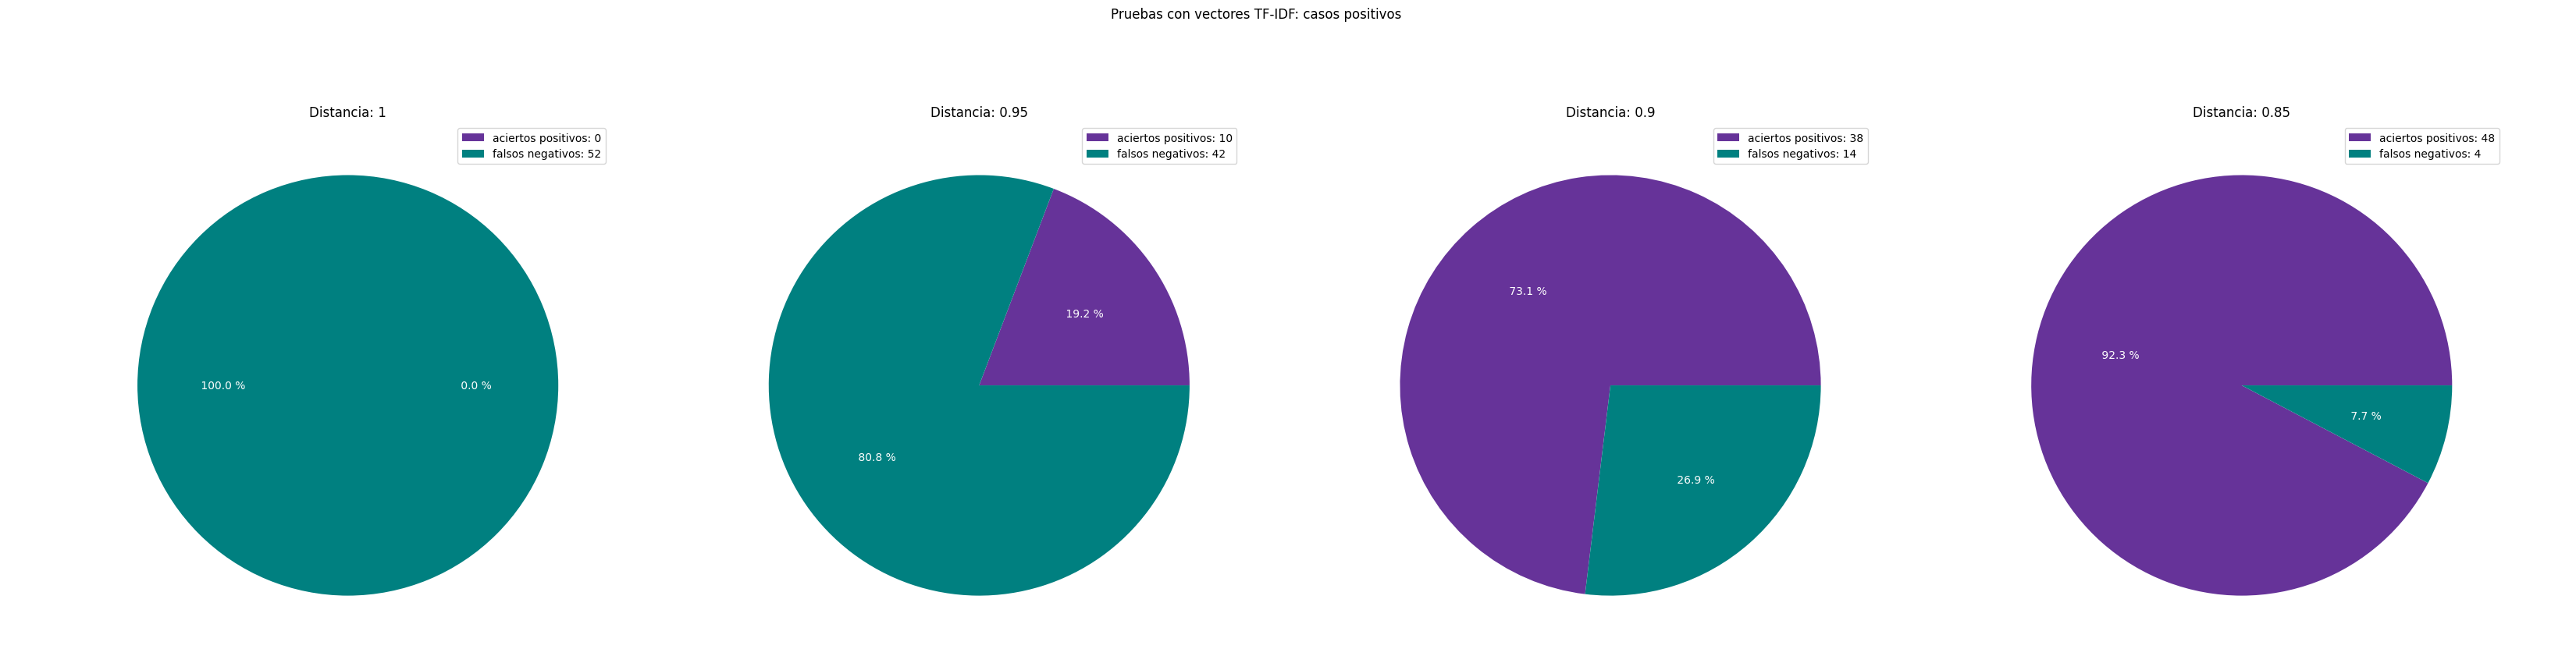

In [ ]:
fig, axes = plt.subplots(1, 4, figsize = (40, 10))
fig.suptitle("Pruebas con vectores TF-IDF: casos positivos")
for index, row in df_results_val.iterrows():
  y = np.array([row['aciertos_positivos'], row['falsos_negativos']])
  mylabels = ['aciertos positivos: ' + str(row['aciertos_positivos']), 'falsos negativos: ' + str(row['falsos_negativos'])]

  axes[index].pie(y, labels = mylabels, autopct ='% 1.1f %%', colors = ['rebeccapurple', 'teal'], textprops={'color':"w"})
  axes[index].set_title("Distancia: " + str(row['distancia']))
  axes[index].legend()

plt.show()

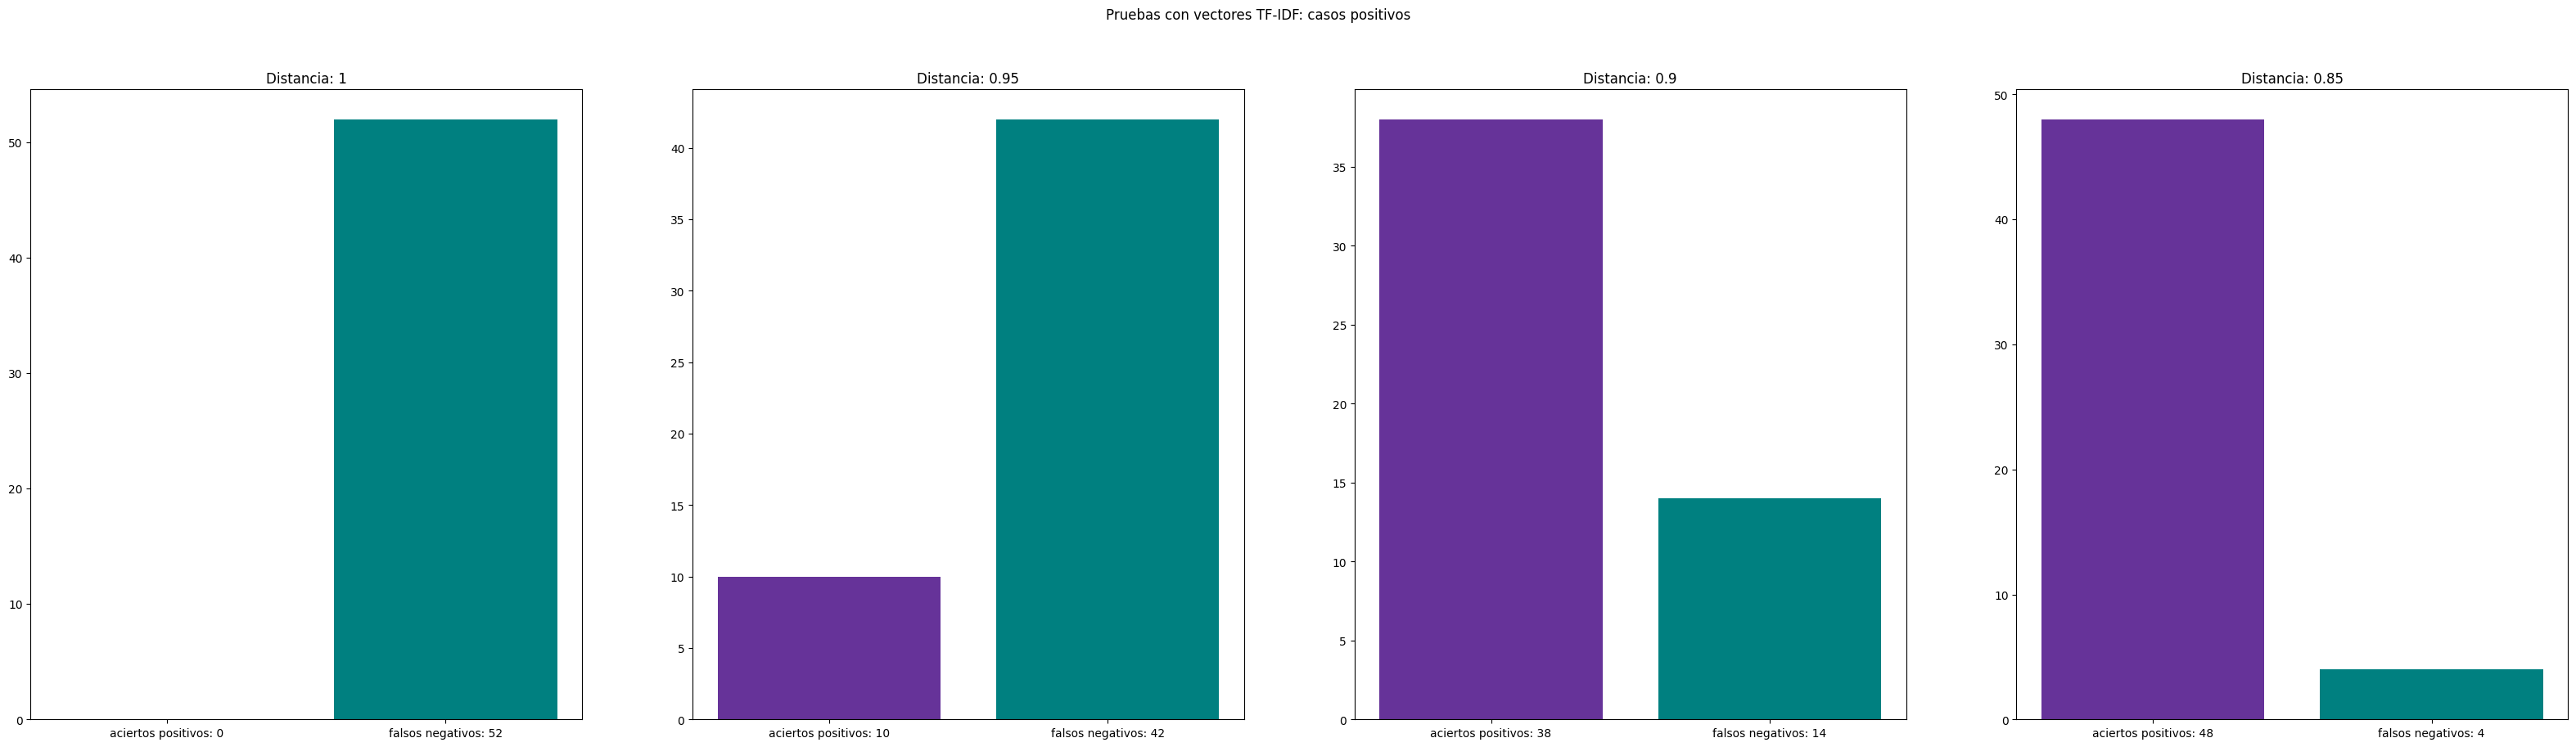

In [ ]:
fig, axes = plt.subplots(1, 4, figsize = (40, 10))
fig.suptitle("Pruebas con vectores TF-IDF: casos positivos")
for index, row in df_results_val.iterrows():
  y = np.array([row['aciertos_positivos'], row['falsos_negativos']])
  mylabels = ['aciertos positivos: ' + str(row['aciertos_positivos']), 'falsos negativos: ' + str(row['falsos_negativos'])]

  axes[index].bar(mylabels, y, color = ['rebeccapurple', 'teal'])
  axes[index].set_title("Distancia: " + str(row['distancia']))

plt.show()

### Casos etiquetados como **negativos**
Se muestran los aciertos negativos y los falsos positivos, que suman los casos que están etiquetados como 0, es decir, los que no tienen ningún autor con el que enlazarse.

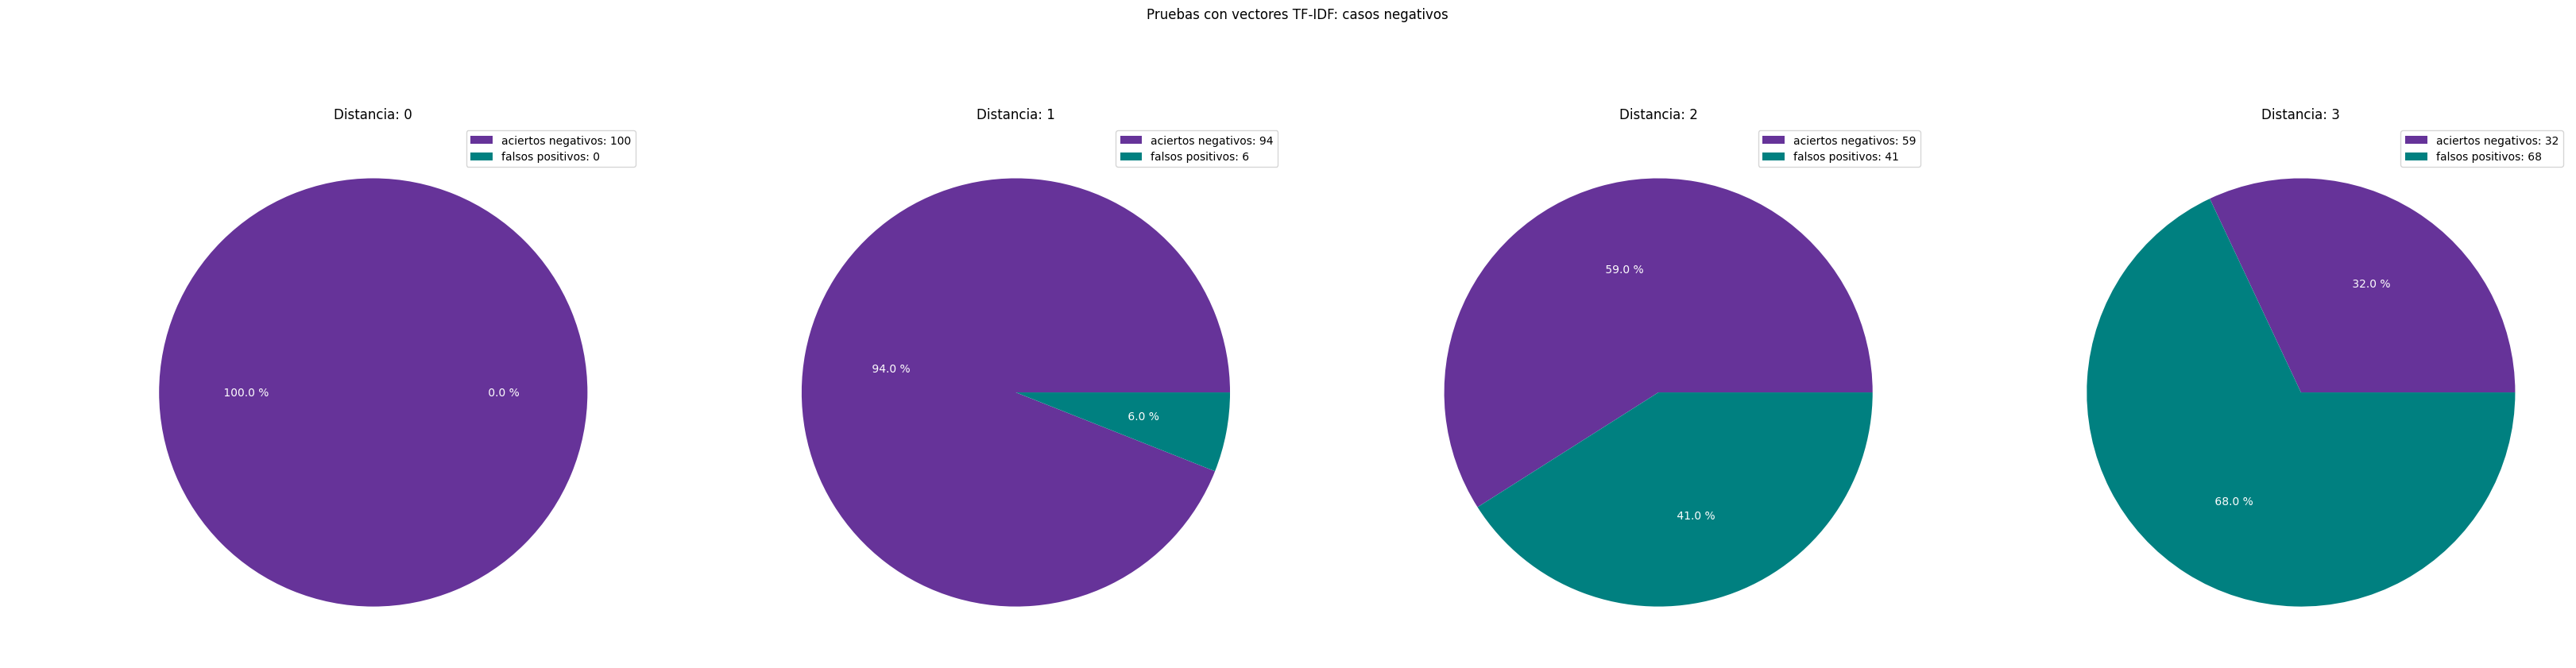

In [ ]:
fig, axes = plt.subplots(1, 4, figsize = (40, 10))
fig.suptitle("Pruebas con vectores TF-IDF: casos negativos")
for index, row in df_results_val.iterrows():
  y = np.array([row['aciertos_negativos'], row['falsos_positivos']])
  mylabels = ['aciertos negativos: ' + str(row['aciertos_negativos']), 'falsos positivos: ' + str(row['falsos_positivos'])]

  axes[index].pie(y, labels = mylabels, autopct ='% 1.1f %%', colors = ['rebeccapurple', 'teal'], textprops={'color':"w"})
  axes[index].set_title("Distancia: " + str(index))
  axes[index].legend()

plt.show()

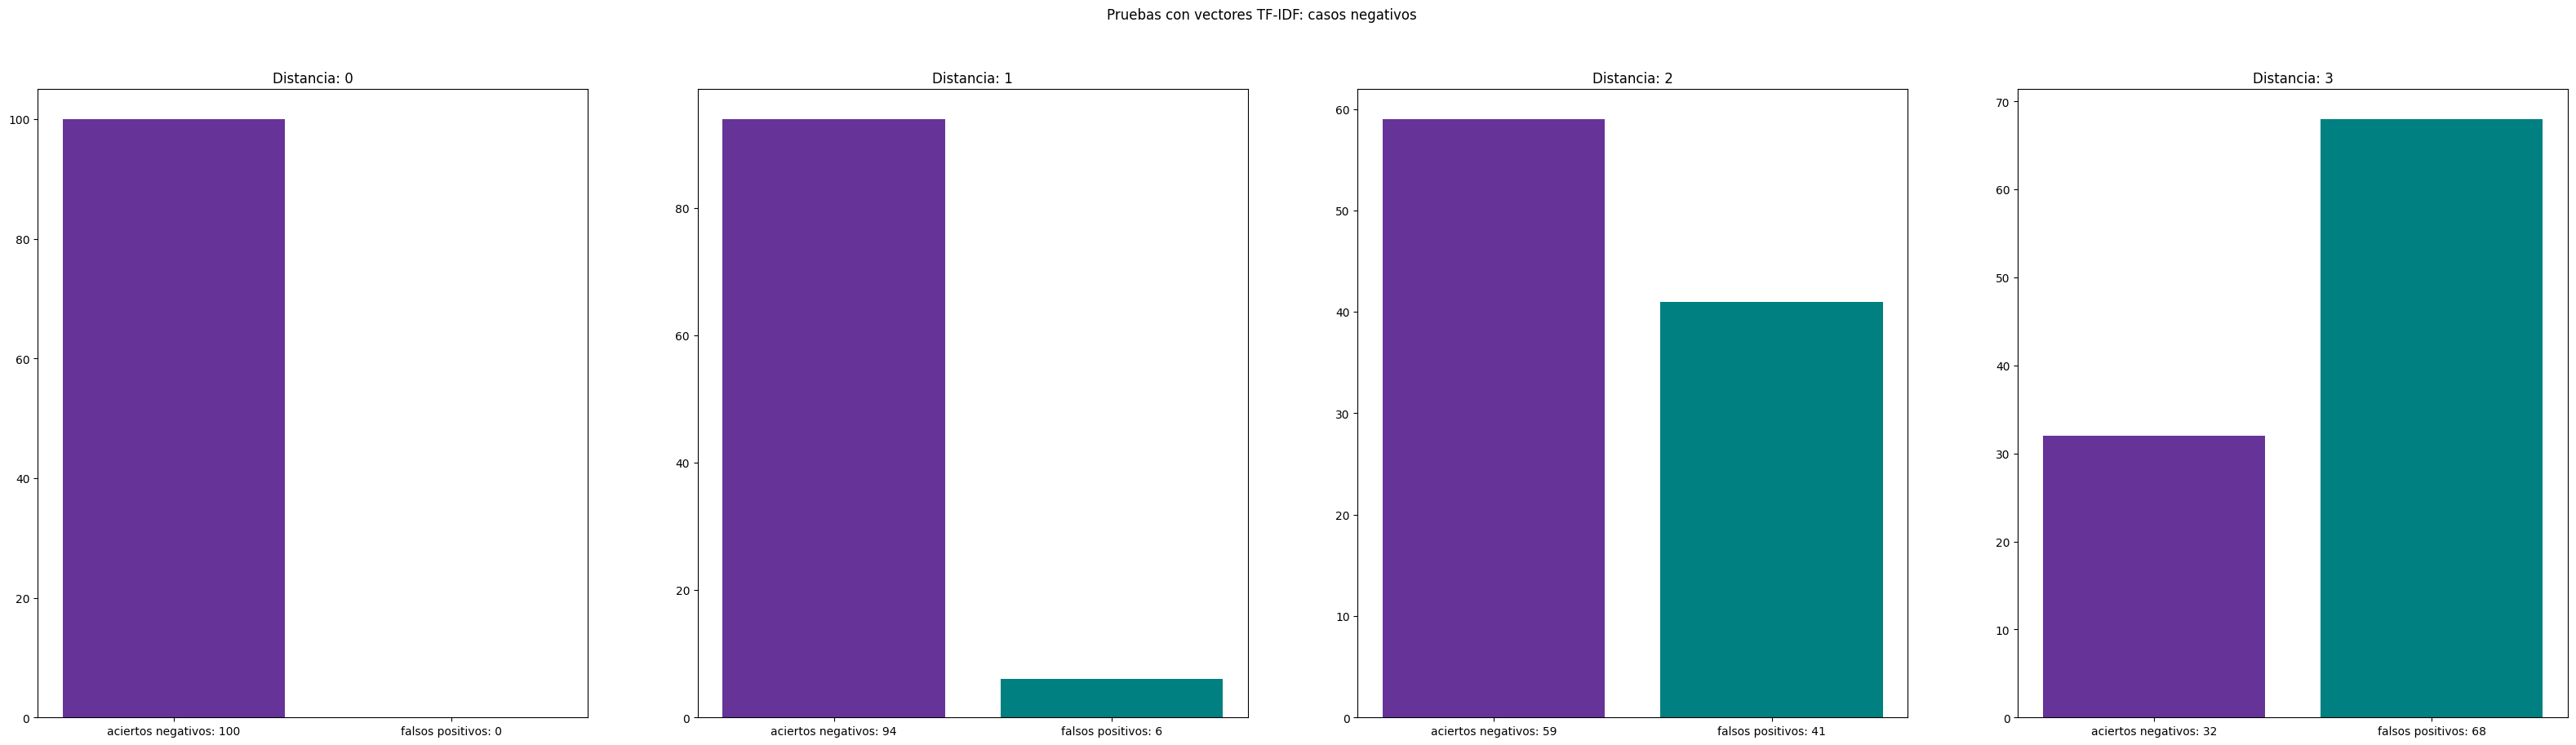

In [ ]:
fig, axes = plt.subplots(1, 4, figsize = (40, 10))
fig.suptitle("Pruebas con vectores TF-IDF: casos negativos")
for index, row in df_results_val.iterrows():
  y = np.array([row['aciertos_negativos'], row['falsos_positivos']])
  mylabels = ['aciertos negativos: ' + str(row['aciertos_negativos']), 'falsos positivos: ' + str(row['falsos_positivos'])]

  axes[index].bar(mylabels, y, color = ['rebeccapurple', 'teal'])
  axes[index].set_title("Distancia: " + str(index))

plt.show()

# Métricas


In [ ]:
df_val_set = pd.read_csv('/content/drive/MyDrive/TFM/notebooks/entrega/bert_result_val.csv', index_col = 0)

In [ ]:
threshold = [1, 0.95, 0.9, 0.85]
test = []
for i in threshold:
  print('Threshold: ' + str(i))
  evaluate_model(df_val_set['label'], (df_val_set['similarity'] >= i))

Threshold: 1
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.66      1.00      0.79       100
           1       0.00      0.00      0.00        52

    accuracy                           0.66       152
   macro avg       0.33      0.50      0.40       152
weighted avg       0.43      0.66      0.52       152

Accuracy -> 65.79%



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Threshold: 0.95
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.69      0.94      0.80       100
           1       0.62      0.19      0.29        52

    accuracy                           0.68       152
   macro avg       0.66      0.57      0.55       152
weighted avg       0.67      0.68      0.62       152

Accuracy -> 68.42%



Threshold: 0.9
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.81      0.59      0.68       100
           1       0.48      0.73      0.58        52

    accuracy                           0.64       152
   macro avg       0.64      0.66      0.63       152
weighted avg       0.70      0.64      0.65       152

Accuracy -> 63.82%



Threshold: 0.85
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.89      0.32      0.47       100
           1       0.41      0.92      0.57        52

    accuracy                           0.53       152
   macro avg       0.65      0.62      0.52       152
weighted avg       0.73      0.53      0.51       152

Accuracy -> 52.63%

